# Dependencies

In [1]:
import pandas as pd
import numpy as np
import json
import re
from nltk.corpus import stopwords
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Importing and Cleaning Data

In [2]:
df = pd.read_json("Data_cyb.json", lines = True, orient = "columns")

In [3]:
rating = []

for i in df["annotation"]:
    rating.append(int(i["label"][0]))
    
df["rating"] = rating

In [4]:
df.head()

,content,annotation,extras,rating
0,Get fucking real dude.,"{'notes': '', 'label': ['1']}",NaN,1
1,She is as dirty as they come and that crook ...,"{'notes': '', 'label': ['1']}",NaN,1
2,why did you fuck it up. I could do it all day...,"{'notes': '', 'label': ['1']}",NaN,1
3,Dude they dont finish enclosing the fucking s...,"{'notes': '', 'label': ['1']}",NaN,1
4,WTF are you talking about Men? No men thats n...,"{'notes': '', 'label': ['1']}",NaN,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 4 columns):
content       20001 non-null object
annotation    20001 non-null object
extras        0 non-null float64
rating        20001 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 625.2+ KB


In [6]:
tweets = pd.read_csv("Test_Twitter_Comments.csv")
tweets.tail()

,content,rating
96,That is someone who does it from their heart. ...,1
97,Absolutely applaud your work to secure freedom...,0
98,You'll never learn it till you actually live i...,1
99,Nothing on the reinstatement of federal Capito...,1
100,Crickets,0


In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
content    101 non-null object
rating     101 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


In [8]:
new_df1 = df[["content", "rating"]]

In [9]:
new_df = pd.concat([new_df1,tweets])

In [10]:
X, X_test, y, y_test = train_test_split(new_df["content"], new_df["rating"], train_size = 0.8)


# Baseline Model

In [11]:
import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(X)
reviews_test_clean = preprocess_reviews(X_test)

In [12]:
baseline_vectorizer = CountVectorizer(binary=True)
baseline_vectorizer.fit(reviews_train_clean)
X_baseline = baseline_vectorizer.transform(reviews_train_clean)
X_test_baseline = baseline_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X_baseline, y, train_size = 0.5
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

c:\users\ajkim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.6592463623927373
Accuracy for C=0.05: 0.7002860340753637
Accuracy for C=0.25: 0.7445591344360154
Accuracy for C=0.5: 0.7598557393359034
Accuracy for C=1: 0.7756497948016415


### Has room to learn

# Remove Stop Words
Removing Stop Words
Stop words are the very common words like ‘if’, ‘but’, ‘we’, ‘he’, ‘she’, and ‘they’. We can usually remove these words without changing the semantics of a text 

In [13]:
from nltk.corpus import stopwords

In [14]:
english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

In [15]:
no_stop_words_train = remove_stop_words(reviews_train_clean)
no_stop_words_test = remove_stop_words(reviews_test_clean)

cv = CountVectorizer(binary=True)
cv.fit(no_stop_words_train)
X = cv.transform(no_stop_words_train)
X_test = cv.transform(no_stop_words_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

c:\users\ajkim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.6831633921909973
Accuracy for C=0.05: 0.7224571002238249
Accuracy for C=0.25: 0.7714498880875404
Accuracy for C=0.5: 0.7853767719472768
Accuracy for C=1: 0.8032827654812236


### Still has room to learn

# Normalization
A common next step in text preprocessing is to normalize the words in your corpus by trying to convert all of the different forms of a given word into one. Two methods that exist for this are Stemming and Lemmatization.


# Stemming

In [16]:
def get_stemmed_text(corpus):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

stemmed_reviews_train = get_stemmed_text(reviews_train_clean)
stemmed_reviews_test = get_stemmed_text(reviews_test_clean)

cv = CountVectorizer(binary=True)
cv.fit(stemmed_reviews_train)
X = cv.transform(stemmed_reviews_train)
X_test = cv.transform(stemmed_reviews_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

c:\users\ajkim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.675951255906491
Accuracy for C=0.05: 0.7169858244217856
Accuracy for C=0.25: 0.7716985824421786
Accuracy for C=0.5: 0.7876150211390202
Accuracy for C=1: 0.8020392937080328


### Still has room to learn

# Lemmatization

In [17]:
def get_lemmatized_text(corpus):
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

lemmatized_reviews_train = get_lemmatized_text(reviews_train_clean)
lemmatized_reviews_test = get_lemmatized_text(reviews_test_clean)

cv = CountVectorizer(binary=True)
cv.fit(lemmatized_reviews_train)
X = cv.transform(lemmatized_reviews_train)
X_test = cv.transform(lemmatized_reviews_test)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

c:\users\ajkim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.6849042526734643
Accuracy for C=0.05: 0.7214623228052723
Accuracy for C=0.25: 0.7719472767968167
Accuracy for C=0.5: 0.7938323800049739
Accuracy for C=1: 0.8109922904750062


### Still has room to learn

# n-grams

Last time we used only single word features in our model, which we call 1-grams or unigrams. We can potentially add more predictive power to our model by adding two or three word sequences (bigrams or trigrams) as well. For example, if a review had the three word sequence “didn’t love movie” we would only consider these words individually with a unigram-only model and probably not capture that this is actually a negative sentiment because the word ‘love’ by itself is going to be highly correlated with a positive review.
The scikit-learn library makes this really easy to play around with.

In [18]:
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 4))
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    
final_ngram = LogisticRegression(C=1)
final_ngram.fit(X, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_ngram.predict(X_test)))

c:\users\ajkim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.7296692365083313
Accuracy for C=0.05: 0.8346182541656304
Accuracy for C=0.25: 0.8716737130067147
Accuracy for C=0.5: 0.8759015170355633
Accuracy for C=1: 0.8739119621984581
Final Accuracy: 0.9089778662024373


### Still has room to learn

# Word Counts

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

wc_vectorizer = CountVectorizer(binary=False)
wc_vectorizer.fit(reviews_train_clean)
X = wc_vectorizer.transform(reviews_train_clean)
X_test = wc_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75, 
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

c:\users\ajkim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.6891320567023128
Accuracy for C=0.05: 0.7264362098980354
Accuracy for C=0.25: 0.7796568017905994
Accuracy for C=0.5: 0.7975627953245461
Accuracy for C=1: 0.8099975130564536


### Still has room to learn

# TF-IDF

Another common way to represent each document in a corpus is to use the tf-idf statistic (term frequency-inverse document frequency) for each word, which is a weighting factor that we can use in place of binary or word count representations.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(reviews_train_clean)
X = tfidf_vectorizer.transform(reviews_train_clean)
X_test = tfidf_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

c:\users\ajkim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.6155185277294205
Accuracy for C=0.05: 0.657796568017906
Accuracy for C=0.25: 0.7271822929619498
Accuracy for C=0.5: 0.7488187018154688
Accuracy for C=1: 0.7791594130813231


### Still has room to learn

# Support Vector Machines (SVM)

Recall that linear classifiers tend to work well on very sparse datasets (like the one we have). Another algorithm that can produce great results with a quick training time are Support Vector Machines with a linear kernel.
Here’s an example with an n-gram range from 1 to 2:

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))

Accuracy for C=0.01: 0.8308878388460582
Accuracy for C=0.05: 0.8731658791345437
Accuracy for C=0.25: 0.8696841581696095
Accuracy for C=0.5: 0.8669485202685899
Accuracy for C=1: 0.8607311614026362


In [22]:
final_svm_ngram = LinearSVC(C=0.05)
final_svm_ngram.fit(X, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_svm_ngram.predict(X_test)))

Final Accuracy: 0.8928127331509574


# Naive Bayes

In [23]:
new_df.to_csv("final_df.csv", index=False)

In [25]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("basics").getOrCreate()

In [27]:
from pyspark import SparkFiles

# Load in user_data.csv from S3 into a DataFrame
spark = SparkSession.builder.master("local").appName("CsvReader").getOrCreate()
spark_df = spark.read.format("csv").option("header", "true").load("final_df.csv")

In [28]:
from pyspark.sql.types import IntegerType

spark_df = spark_df.withColumn("rating1", spark_df["rating"].cast(IntegerType()))
spark_df = spark_df.drop(spark_df.rating)
spark_df = spark_df.withColumnRenamed("rating1", "rating")

In [29]:
from pyspark.sql.functions import regexp_extract, length
review_df = spark_df.withColumnRenamed("rating", "label")\
      .withColumnRenamed("content", "review_text")\
      .select(["label", "review_text"])
review_df = review_df.withColumn('review_length', length(review_df['review_text'])).dropna()
review_df.cache()

DataFrame[label: int, review_text: string, review_length: int]

In [30]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

# Create all the features to the data set
tokenizer = Tokenizer(inputCol="review_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
hashingTF = HashingTF(inputCol="token_text", outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')

In [31]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token', 'review_length'], outputCol='features')

In [32]:
# Create and run a data processing Pipeline
from pyspark.ml import Pipeline
data_prep_pipeline = Pipeline(stages=[tokenizer, stopremove, hashingTF, idf, clean_up])

In [33]:
# Fit and transform the pipeline
cleaner = data_prep_pipeline.fit(review_df)
cleaned = cleaner.transform(review_df)

In [34]:
from pyspark.ml.classification import NaiveBayes
# Break data down into a training set and a testing set
training, testing = cleaned.randomSplit([0.7, 0.3])

# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

In [35]:
# Tranform the model with the testing data
test_results = predictor.transform(testing)
test_results.show(5)

+-----+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|         review_text|review_length|          token_text|         stop_tokens|          hash_token|           idf_token|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    0|   Santa is Itali...|           67|[, , , santa, is,...|[, , , santa, ita...|(262144,[15889,23...|(262144,[15889,23...|(262145,[15889,23...|[-814.41941707439...|[0.99999783980167...|       0.0|
|    0|   &amp;i love you(:|           19|[, , &amp;i, love...|[, , &amp;i, love...|(262144,[186480,1...|(262144,[186480,1...|(262145,[186480,1...|[-276.98639030277...|[0.99999999904929...|       

In [36]:
# Use the Class Evaluator for a cleaner description
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting reviews was: %f" % acc)

Accuracy of model at predicting reviews was: 0.806096


# Final Model

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords

In [57]:
stop_words = stopwords.words('english')
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
ngram_vectorizer.fit(reviews_train_clean)
X = ngram_vectorizer.transform(reviews_train_clean)
X_test = ngram_vectorizer.transform(reviews_test_clean)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size = 0.5
)

ccc = []
c_scores = []

for c in [0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))
    ccc.append(c)
    c_scores.append(accuracy_score(y_val, svm.predict(X_val)))   

Accuracy for C=0.04: 0.811217510259918
Accuracy for C=0.05: 0.8105956970526054
Accuracy for C=0.06: 0.8092277079965179
Accuracy for C=0.07: 0.8092277079965179
Accuracy for C=0.08: 0.8096007959209054
Accuracy for C=0.09: 0.8087302574306678
Accuracy for C=0.1: 0.8077353562989678
Accuracy for C=0.11: 0.8072379057331178
Accuracy for C=0.12: 0.8067404551672678
Accuracy for C=0.13: 0.8062430046014177
Accuracy for C=0.14: 0.8054968287526427
Accuracy for C=0.15: 0.8054968287526427


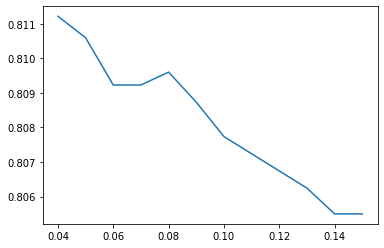

In [58]:
import matplotlib.pyplot as plt    
                    
plt.plot(ccc, c_scores)
plt.show()

In [59]:
final = LinearSVC(tol=.000001,C=0.06)
final.fit(X, y)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final.predict(X_test)))

Final Accuracy: 0.8985327033076349


# Let's test this baby out!

In [41]:
tweets_list = [i[1]["content"] for i in tweets.iterrows()]
rating_list = [i[1]["rating"] for i in tweets.iterrows()]

In [42]:
twitter_cleaned = preprocess_reviews(tweets_list)
len(twitter_cleaned)

101

In [43]:
tws = ngram_vectorizer.transform(twitter_cleaned)
tws.shape

(101, 138962)

In [44]:
predictions = final.predict(tws[:100])

In [45]:
pd.DataFrame({"Prediction": predictions, "Actual": rating_list[:100]}).reset_index(drop=True).head()

,Prediction,Actual
0,0,0
1,0,0
2,0,1
3,1,1
4,1,1


In [46]:
total = 0
score = 0
for i, j in zip(predictions, rating_list):
    total += 1
    if i == j:
        score += 1
        
print(f"Accuracy: {score/total}")

Accuracy: 0.84


# Save & Load Model

In [47]:
from sklearn.externals import joblib

c:\users\ajkim\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [48]:
joblib.dump(final, "final_model_svc.pkl")

['final_model_svc.pkl']

In [49]:
try:
    retrieve_model = joblib.load("final_model_svc.pkl")
    print("using trained model")
except:
    print("model not found")
    joblib.dump(final, "final_model_svc.pkl")

using trained model
